<a href="https://colab.research.google.com/github/LoopMint/angelatancapstone-app/blob/main/CP_Read_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use Gradio to create web apps that displays csv data onto an interactive user interface**

In [1]:
#use the latest version
!pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.10.1
    Uninstalling gradio_client-1.10.1:
      Successfully uninstalled gradio_client-1.10.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.31.0
    Uninstalling gradio-5.31.0:
      Successfully uninstalled gradio-5.31.0


# **Use ReportLab library to download into PDF**

In [2]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.4 MB/s eta 0:00:00


#**Use TensorFlow to build neural networks and train models to make predictions on university rankings**

In [3]:
!pip install tensorflow

# **Prompt user to upload the QS Ranking CSV File**

In [4]:
from google.colab import files

#triggers a file picker dialog in browser
uploaded = files.upload()

# Get the uploaded file name dynamically
for fn in uploaded.keys():
    file_path = fn
    print(f"File uploaded: {file_path}")


Saving QSRanking.csv to QSRanking.csv
File uploaded: QSRanking.csv


# **Import libraries**

*   pandas as pd → for loading CSV
*   gradio as gr → for building the interactive web app & dashboard.
*   tensorflow / keras → for building and training deep learning models (classification, regression, Siamese).
*   numpy as np → for numerical operations.
*   sklearn.preprocessing.StandardScaler → scales your features so they have mean =  0 and standard deviation = 1  #this is a data preprocessing tool for dataset to make DLM accurate and stable, otherwise bias towards large numeric values.
*   sklearn.model_selection.train_test_split → splits data into training + testing validation sets.
*   matplotlib.pyplot as plt → creates charts and plots.
*   io.BytesIO + base64 → converts plots/images so they can be displayed in Gradio.
*   reportlab → generates PDF reports (eg. for pairwise ranking analysis).
*   tempfile → creates temporary files for storing charts and PDFs before download.
*   os → interact with operating system

📊 Total records: 1403 universities


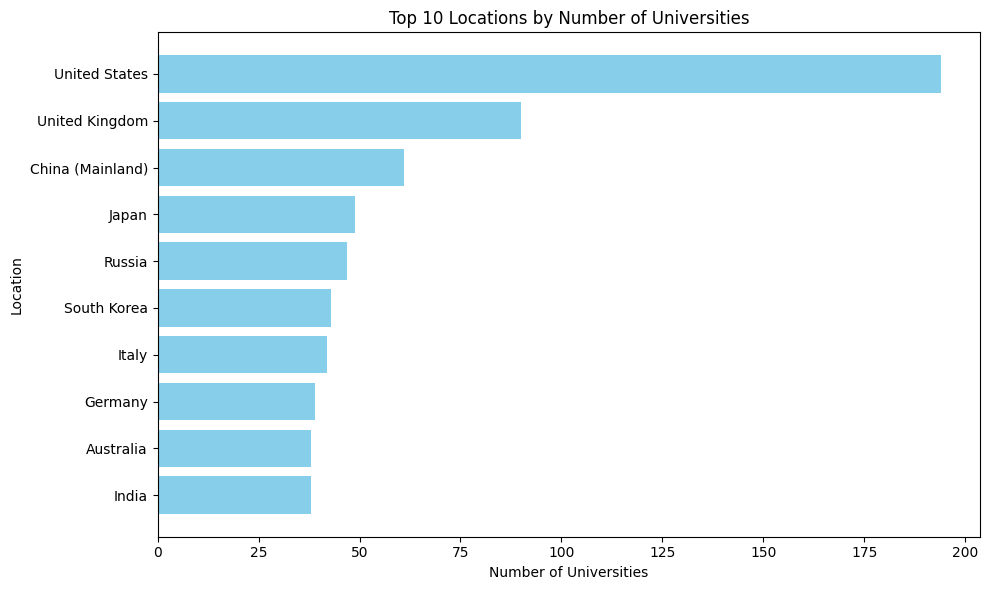

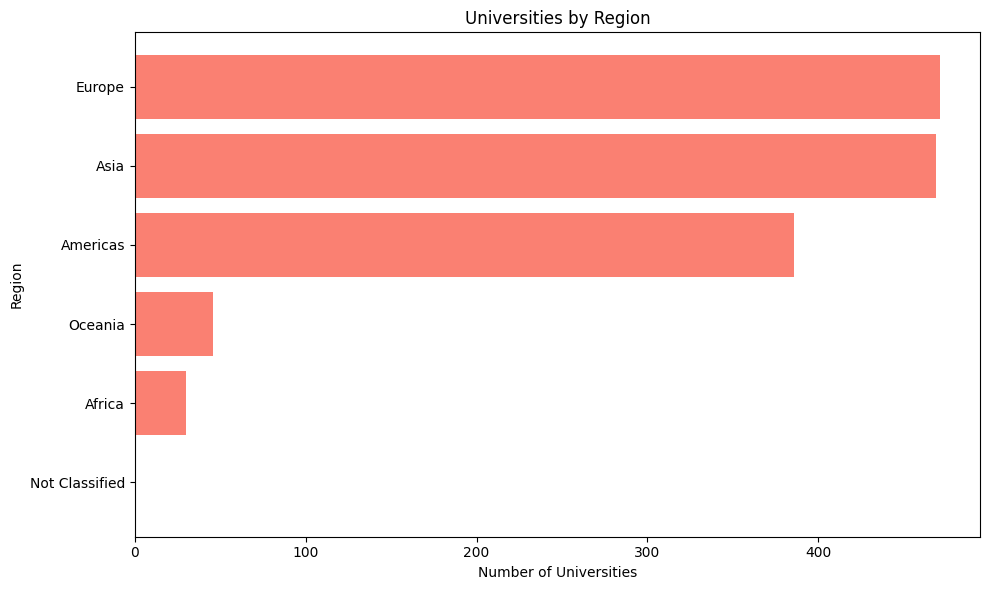

Epoch 1/20
36/36 - 2s - 48ms/step - accuracy: 0.8155 - loss: 0.5506 - val_accuracy: 0.9324 - val_loss: 0.3437
Epoch 2/20
36/36 - 0s - 5ms/step - accuracy: 0.9421 - loss: 0.2704 - val_accuracy: 0.9609 - val_loss: 0.1671
Epoch 3/20
36/36 - 0s - 6ms/step - accuracy: 0.9545 - loss: 0.1532 - val_accuracy: 0.9680 - val_loss: 0.1037
Epoch 4/20
36/36 - 0s - 5ms/step - accuracy: 0.9697 - loss: 0.1026 - val_accuracy: 0.9715 - val_loss: 0.0819
Epoch 5/20
36/36 - 0s - 5ms/step - accuracy: 0.9750 - loss: 0.0807 - val_accuracy: 0.9715 - val_loss: 0.0718
Epoch 6/20
36/36 - 0s - 4ms/step - accuracy: 0.9786 - loss: 0.0704 - val_accuracy: 0.9715 - val_loss: 0.0628
Epoch 7/20
36/36 - 0s - 9ms/step - accuracy: 0.9688 - loss: 0.0670 - val_accuracy: 0.9715 - val_loss: 0.0599
Epoch 8/20
36/36 - 0s - 9ms/step - accuracy: 0.9759 - loss: 0.0562 - val_accuracy: 0.9715 - val_loss: 0.0582
Epoch 9/20
36/36 - 0s - 5ms/step - accuracy: 0.9777 - loss: 0.0620 - val_accuracy: 0.9680 - val_loss: 0.0585
Epoch 10/20
36/36 

In [ ]:
# Load libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import metrics
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os
import gradio as gr

# Load and clean data
file_path = 'QSRanking.csv'  # replace with your actual path

# Latin1 tell python to read special char and symbol in csv format
df = pd.read_csv(file_path, encoding='latin1')

# Drop past year record
if 'RANK_2024' in df.columns:
    df = df.drop(columns=['RANK_2024'])

# Change data to numbers for the selected column and fill nan with lowest bottom-ranked by default (last record)
df['RANK_2025'] = pd.to_numeric(df['RANK_2025'], errors='coerce').fillna(1402)

# Checks if each university rank is within 100 and assign 1 if true
df['Top100'] = np.where(df['RANK_2025'] <= 100, 1, 0)

# Train the model using this list to predict final rank
feature_cols = ['Academic_Reputation_Score', 'Employer_Reputation_Score',
                'Citations_per_Faculty_Score', 'Faculty_Student_Score',
                'International_Faculty_Score']

# Train model to remove data in rows where columns are missing
df = df.dropna(subset=feature_cols + ['Institution_Name', 'Top100'])

# Only take the important score columns from the dataset to use as the inputs (features)
X = df[feature_cols].values
y_class = df['Top100'].values       # For classification (Top 100)
y_reg = df['RANK_2025'].values      # For regression (rank prediction)

comparison_features = [
    "Academic_Reputation_Rank",
    "Employer_Reputation_Rank",
    "Faculty_Student_Rank",
    "Citations_per_Faculty_Rank",
    "International_Students_Rank",
    "Employment_Outcomes_Rank",
    "Sustainability_Rank",
    "International_Research_Network_Rank"
]

# Summary statistics of usable records
print(f"📊 Total records: {df.shape[0]} universities")

# Show chart by Top 10 Locations
if 'Location' in df.columns:
    loc_counts = df['Location'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    plt.barh(loc_counts.index[::-1], loc_counts.values[::-1], color='skyblue')
    plt.title("Top 10 Locations by Number of Universities")
    plt.xlabel("Number of Universities")
    plt.ylabel("Location")
    plt.tight_layout()
    plt.show()

# Show chart by Region
if 'Region' in df.columns:
    reg_counts = df['Region'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.barh(reg_counts.index[::-1], reg_counts.values[::-1], color='salmon')
    plt.title("Universities by Region")
    plt.xlabel("Number of Universities")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()

# Preprocessing for neural networks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Classification Model (Top 100 Prediction)
X_train, X_val, y_train_c, y_val_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)   #Commonly used is 80/20 split for balance, enough to learn and test. 42 is a commonly used number in data science world for this type of training/testing data.
model_class = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),   #64 is a moderate size enough to learn patterns in medium datasets, not too large to slow down training, next layer is 32. Too few neurons is too simple to learn patterns, too many neurons is complex and take longer to train. 62-32 is common rule of thumb for moderate size like 1K-100K records.
    layers.Dropout(0.3),         #30% drop is a good balance as the usual default for this dataset I'm using.
    layers.Dense(32, activation='relu'),  #Relu means Rectified Linear Unit helps the network learn non-linear patterns in the data, like output x if x>0
    layers.Dense(1, activation='sigmoid')  #output to a range between 0 and 1 to decide final class if in top 100
])

#tells model how to learn, measure errors and report during training
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model will go through training 20times, too many epoch training will cause memorising instead of learning. Verbose controls how much output to see during training say 0, no output at all or 2 for one line per epoch as updates
model_class.fit(X_train, y_train_c, epochs=20, validation_data=(X_val, y_val_c), verbose=2)

# Regression Model (Rank Estimation using training and validation prediction)
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
model_reg = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_reg.fit(X_train_r, y_train_r, epochs=20, validation_data=(X_val_r, y_val_r), verbose=2)

# Evaluate Regression Model (how well it performs on unseen data)
y_pred = model_reg.predict(X_val_r) # Use X_val_r and y_val_r for evaluation
mae = mean_absolute_error(y_val_r, y_pred)    #measures how far off the predictions are on average.
mse = mean_squared_error(y_val_r, y_pred)  #detecting large deviations
r2 = r2_score(y_val_r, y_pred)              #How much of ranking pattern does the model understand”

# Show Evaluation Scores
# Assuming st is streamlit, which is not imported. Replacing with print for now.
print("📊 Regression Model Evaluation")
print("Model trained to predict QS RANK_2025 based on academic metrics.")

metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score'],
    'Value': [mae, mse, r2]
})
print(metrics_df)

# Siamese Model (for Comparison)
# Specifically designed to compare two inputs and learn patterns based on features like academic reputation etc

def build_siamese_model(input_dim):        #define and build features like reputation score etc into input dim
    base = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu')
    ])
    input_a = Input(shape=(input_dim,))      #one input for university A
    input_b = Input(shape=(input_dim,))      #one input for university B
    encoded_a = base(input_a)
    encoded_b = base(input_b)
    diff = layers.Subtract()([encoded_a, encoded_b])   #measure how different they area
    out = layers.Dense(1, activation='sigmoid')(diff)  #pass difference through single output 1 if uni A is better ranked or 0 if uni B is better ranked
    return Model([input_a, input_b], out)              #return to full model to predict which is better

model_rank = build_siamese_model(X.shape[1])
model_rank.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  #build the model to compare and make predictions based on features on which rank better

# Train Siamese model for comparison where x represent features like citations etc and y represent QS ranking of each uni
def create_pairs(X, y_rank):
    pairs_a, pairs_b, labels = [], [], []   # pair_a stores Uni A etc, label tells model who is better eg. 1 if one of the uni is ranked higher
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            pairs_a.append(X[i])
            pairs_b.append(X[j])
            labels.append(1 if y_rank[i] < y_rank[j] else 0)
    return np.array(pairs_a), np.array(pairs_b), np.array(labels)

X_a, X_b, y_rank_pair = create_pairs(X_scaled, y_reg)
model_rank.fit([X_a, X_b], y_rank_pair, epochs=5, batch_size=256, verbose=2)  #see training set 5 times and predict which uni rank better per 256 samples

def compare_reputation(univ_a, univ_b):
    u1 = df[df['Institution_Name'].str.lower().str.contains(univ_a.lower())]
    u2 = df[df['Institution_Name'].str.lower().str.contains(univ_b.lower())]

    if not u1.empty and not u2.empty:
        uni_names = [u1.iloc[0]['Institution_Name'], u2.iloc[0]['Institution_Name']]
        rep_scores = [
            [u1.iloc[0]["Academic_Reputation_Score"], u2.iloc[0]["Academic_Reputation_Score"]],
            [u1.iloc[0]["Employer_Reputation_Score"], u2.iloc[0]["Employer_Reputation_Score"]],
            [u1.iloc[0]["Faculty_Student_Score"], u2.iloc[0]["Faculty_Student_Score"]],
            [u1.iloc[0]["Citations_per_Faculty_Score"], u2.iloc[0]["Citations_per_Faculty_Score"]],
            [u1.iloc[0]["International_Faculty_Score"], u2.iloc[0]["International_Faculty_Score"]],
        ]

        # Calculate total and % score
        scores_a = [s[0] for s in rep_scores]
        scores_b = [s[1] for s in rep_scores]
        total_a = sum(scores_a)
        total_b = sum(scores_b)
        percent_a = (total_a / (total_a + total_b)) * 100
        percent_b = (total_b / (total_a + total_b)) * 100
        better_uni = uni_names[0] if total_a > total_b else uni_names[1]

        # Chart labels
        labels = ["Academic Reputation", "Employer Reputation", "Faculty Student", "Citations per Faculty", "International Faculty"]
        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width/2, scores_a, width, label=uni_names[0], color='skyblue')
        ax.bar(x + width/2, scores_b, width, label=uni_names[1], color='salmon')
        ax.set_ylabel("Score")
        ax.set_title("Reputation Metrics Comparison")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()

        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        encoded = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()

        chart_html = f'<img src="data:image/png;base64,{encoded}"/>'

        explanation = (
            f"Reputation comparison between {uni_names[0]} and {uni_names[1]} across 5 metrics.\n\n"
            f"{uni_names[0]} contributes **{percent_a:.1f}%**, while {uni_names[1]} contributes **{percent_b:.1f}%** "
            f"to the combined reputation score.\n\n"
            f"🎓 **{better_uni}** has the stronger overall reputation based on these academic metrics."
        )

        return explanation, chart_html
    else:
        return "One or both universities not found.", ""


def plot_location_chart():
    if 'Location' in df.columns:
        loc_counts = df['Location'].value_counts().nlargest(15)
        plt.figure(figsize=(10, 6))
        plt.barh(loc_counts.index[::-1], loc_counts.values[::-1], color='skyblue')
        plt.title("Top 15 Locations by Number of Universities")
        plt.xlabel("Number of Universities")
        plt.ylabel("Location")
        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        encoded = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()
        return f'<img src="data:image/png;base64,{encoded}"/>'
    return ""

def plot_region_chart():
    if 'Region' in df.columns:
        reg_counts = df['Region'].value_counts()
        plt.figure(figsize=(10, 6))
        plt.barh(reg_counts.index[::-1], reg_counts.values[::-1], color='salmon')
        plt.title("Universities by Region")
        plt.xlabel("Number of Universities")
        plt.ylabel("Region")
        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        encoded = base64.b64encode(buf.read()).decode('utf-8')
        plt.close()
        return f'<img src="data:image/png;base64,{encoded}"/>'
    return ""

# Show Top 10 Chart by QS Rank 2025 using matplotlib
def show_top10():
    top10_df = df.nsmallest(10, 'RANK_2025')[['Institution_Name', 'RANK_2025']]
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(top10_df['Institution_Name'][::-1], top10_df['RANK_2025'][::-1], color='purple')
    ax.set_title("Top 10 Universities (QS RANK 2025)")
    ax.set_xlabel("QS Rank")
    ax.set_ylabel("University")
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    return f'<img src="data:image/png;base64,{encoded}"/>'

# Gradio Interface
with gr.Blocks() as demo:       #build and store under variable named demo
    gr.Markdown("## 2025 QS University Ranking AI Dashboard")    #markdown is formatted text
    gr.Markdown("Data source: Kaggle QS World University Rankings 2025")

# New Tab - Dataset Overview
    with gr.Tab("📄 Raw Dataset"):    #create clickable tab section in app to avoid long cluttered page
        gr.Dataframe(value=df, label="University Dataset", interactive=False, wrap=True)
        total_records = df.shape[0]     #calculate since first row and store in variable
        total_regions = df['Region'].nunique() if 'Region' in df.columns else "N/A"  #check if region exist and count unique regions or put NA
        total_locations = df['Location'].nunique() if 'Location' in df.columns else "N/A"
        summary = (
            f"**Total Records:** {total_records} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Regions:** {total_regions} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Locations:** {total_locations}"
        )
        gr.Markdown(summary)

# Display Charts
    gr.Markdown("### Top 15 Locations")
    gr.HTML(plot_location_chart())
    gr.Markdown("### Universities by Region")
    gr.HTML(plot_region_chart())      #create bar chart using matplotlib

# Ranking Prediction
    with gr.Tab("University Ranking Prediction"):
        univ_input = gr.Textbox(label="Enter university name:")
        model_type = gr.Radio(["Classification", "Regression"], label="Select model type:")
        predict_button = gr.Button("Predict")
        prediction_output1 = gr.Textbox(label="Prediction Result 1")
        prediction_output2 = gr.Textbox(label="Prediction Result 2")

        gr.Markdown("## 📊 Regression Model Evaluation")
        gr.Markdown("Model trained to predict QS RANK_2025 based on academic metrics.")
        gr.Dataframe(value=metrics_df, label="Evaluation Metrics", interactive=False)

        gr.Markdown("""
    💡 **Note**:
    - Regression model checks how close the model's predicted rank is to the actual QS rank. MAE means predictions are off from actual QS rank by ±value ranks on average. MSE is the average of squared differences between predictions and actual values. High value means extreme errors.
    - R² Score suggests the model explains % of the variation in QS ranking due to other factors can't be seen (e.g. prestige, partnerships). Perfect model is 1 (100%) or above 70% is good and reliable for estimation.
      """)


# Show comparison of two universities
    with gr.Tab("Pairwise Ranking"):
        with gr.Row():
            univ_a = gr.Textbox(label="University A")
            univ_b = gr.Textbox(label="University B")
        compare_button = gr.Button("Compare")
        comparison_message = gr.Textbox(label="Comparison Result", lines=4)
        comparison_chart = gr.HTML(label="Visual Comparison")

# Show Top 10 universities
    with gr.Tab("Top 10 Universities"):
        top10_image = gr.HTML()

# Connect buttons
    predict_button.click(predict_university, inputs=[univ_input, model_type], outputs=[prediction_output1, prediction_output2])
    compare_button.click(compare_reputation, inputs=[univ_a, univ_b], outputs=[comparison_message, comparison_chart])
    demo.load(show_top10, outputs=top10_image)

#Launch gradio app in browser
demo.launch(debug=True)